# Crank-Nicolson Scheme

In [2]:
#Use the implicit parabolic PDE Crank-Nicolson Scheme

In [9]:
#import necessary 
import numpy
from matplotlib import pyplot
from scipy import linalg
%matplotlib inline

In [10]:
#parameter setup
L = 1.0
nx = 21
dx = L / (nx - 1)
alpha = 1.22e-3
q = 0.0 #temp gradient

#define x
x = numpy.linspace(0.0, L, num = nx)

T0 = numpy.zeros(nx)
T0[0] = 100.0


In [11]:
def lhs_operator(N, sigma):
    """Compute left hand side"""
    #diagonal of the operator
    D = numpy.diag(2.0 * (1.0 + 1.0 / sigma) * numpy.ones(N))
    D[-1, -1] = 1.0 + 2.0 / sigma 
    #upper and lower
    U = numpy.diag(-1 * numpy.ones(N - 1), k = 1)
    L = numpy.diag(-1 * numpy.ones(N - 1), k = -1)
    #assembly
    lhs = D + U + L
    return lhs

In [12]:
def rhs_vector(T, sigma, qdx):
    """Compute right hand side"""
    b = T[:-2] + 2.0 * (1.0 / sigma - 1.0) * T[1:-1] + T[2:]
    b[0] += T[0] #D-condition
    b[-1] += qdx
    return b

In [13]:
def c_n(T0, nt, dt, dx, alpha, q=0):
    """Define crank-nicolson solution mechanism"""
    sigma = alpha * dt / dx**2
    A = lhs_operator(len(T0) - 2, sigma)
    T = T0.copy()
    for n in range(nt):
        #gen rhs
        b = rhs_vector(T, sigma, q * dx)
        #generator new T
        T[1:-1] = linalg.solve(A,b)
        #neumann BC
        T[-1] = T[-2] + q * dx
    return T

In [14]:
sigma = 0.5
dt = sigma * dx**2 / alpha 
nt = 10

T = c_n(T0, nt, dt, dx, alpha, q)

(0.0, 100.0)

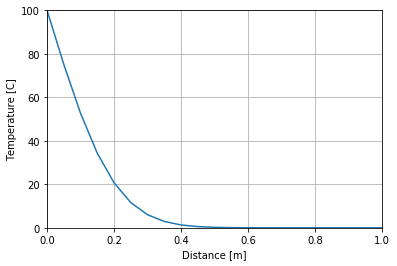

In [15]:
pyplot.figure()
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0)

In [20]:
def ana_temp(x, t, alpha, L, N):
    """compute close to exact temperature"""
    T = 100.0 * numpy.ones_like(x)
    for n in range(1, N + 1):
        k = (2 * n - 1) * numpy.pi / (2.0 * L)
        T -= (400.0 / (2.0 * L * k) * 
             numpy.sin(k * x) * numpy.exp(- alpha * k**2 * t))
        
    return T

In [21]:
T_ex = ana_temp(x, nt * dt, alpha, L, 100)

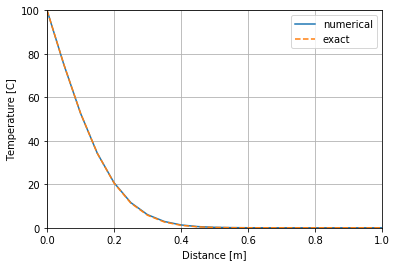

In [25]:
pyplot.figure()
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, label='numerical')
pyplot.plot(x, T_ex, label='exact', linestyle='--')
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0)
pyplot.legend();

# convergence

In [27]:
def l2_error(T, T_ex):
    """compute L2 norm"""
    error = numpy.sqrt(numpy.sum((T - T_ex)**2) / 
                      numpy.sum(T_ex**2))
    return error

In [31]:
#just going to copy and paste the previous implicit method
def lhs_operator_btcs(N, sigma):
    """
    Computes and returns the implicit operator
    of the system for the 1D diffusion equation.
    We use backward Euler method, Dirichlet condition
    on the left side of the domain and zero-gradient
    Neumann condition on the right side.
    
    Parameters
    ----------
    N : integer
        Number of interior points.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size N by N.
    """
    # Setup the diagonal of the operator.
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1.0 + 1.0 / sigma
    # Setup the upper diagonal of the operator.
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A

In [29]:
def rhs_vector_btcs(T, sigma, qdx):
    """
    Computes and returns the right-hand side of the system
    for the 1D diffusion equation, using a Dirichlet condition
    on the left side and a Neumann condition on the right side.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    sigma : float
        Value of alpha * dt / dx**2.
    qdx : float
        Value of the temperature flux at the right side.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side of the system as a 1D array of floats.
    """
    b = T[1:-1] / sigma
    # Set Dirichlet condition.
    b[0] += T[0]
    # Set Neumann condition.
    b[-1] += qdx
    return b

In [30]:
def btcs_implicit(T0, nt, dt, dx, alpha, q):
    """
    Computes and returns the temperature along the rod
    after a given number of time steps.
    
    The function uses Euler implicit in time,
    central differencing in space, a Dirichlet condition
    on the left side, and a Neumann condition on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution
        as a 1D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Distance between two consecutive locations.
    alpha : float
        Thermal diffusivity of the rod.
    q : float
        Value of the temperature gradient on the right side.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    """
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator_btcs(len(T0) - 2, sigma)
    # Integrate in time.
    T = T0.copy()
    for n in range(nt):
        # Generate the right-hand side of the system.
        b = rhs_vector_btcs(T, sigma, q * dx)
        # Solve the system with scipy.linalg.solve.
        T[1:-1] = linalg.solve(A, b)
        # Apply the Neumann boundary condition.
        T[-1] = T[-2] + q * dx
    return T

In [32]:
# new parameters
nx = 1001
dx = L / (nx - 1)

x = numpy.linspace(0.0, L, num = nx)

dt_values = [1.0, 0.5, 0.25, 0.125] #different time step values
errors = []
errors_btcs = []

t0 = 1.0
T0 = ana_temp(x, t0, alpha, L, 100)
t = 10.0
T_exact = ana_temp(x, t, alpha, L, 100)

#compute errors
for dt in dt_values:
    nt = int((t - t0) / dt)
    T = c_n(T0, nt, dt, dx, alpha, q)
    errors.append(l2_error(T, T_exact))
    T = btcs_implicit(T0, nt, dt, dx, alpha, q)
    errors_btcs.append(l2_error(T, T_exact))

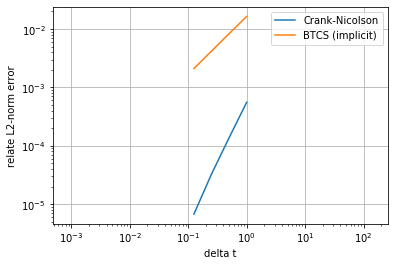

In [34]:
pyplot.figure()
pyplot.grid()
pyplot.xlabel('delta t')
pyplot.ylabel('relate L2-norm error')
pyplot.loglog(dt_values, errors, label='Crank-Nicolson')
pyplot.loglog(dt_values, errors_btcs, label='BTCS (implicit)')
pyplot.legend()
pyplot.axis('equal');

In [35]:
errors

[0.0005562525604218807,
 0.0001374575644790147,
 3.2851704285184806e-05,
 6.77164746861153e-06]

In [36]:
#for each drop by half in time step size, decrease in step by 4. second order in time

In [44]:
dt = 0.1
t = 1000.0
nt = int(t / dt)

nx_values = [11, 21, 41, 81, 161]
errors = []

for nx in nx_values:
    dx = L / (nx - 1)
    x = numpy.linspace(0.0, L, num=nx)
    T0 = numpy.zeros(nx)
    T0[0] = 100.0
    T = c_n(T0, nt, dt, dx, alpha, q)
    T_exact = ana_temp(x, t, alpha, L, 100)
    errors.append(l2_error(T, T_exact))

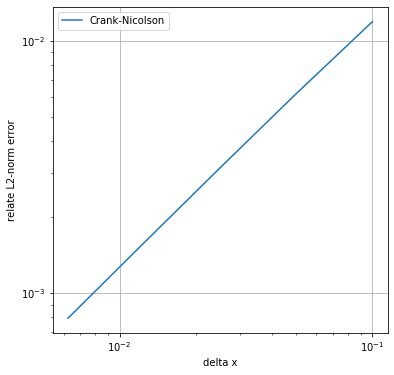

In [45]:
pyplot.figure(figsize=(6.0, 6.0))
pyplot.grid()
pyplot.xlabel('delta x')
pyplot.ylabel('relate L2-norm error')
dx_values = L / (numpy.array(nx_values) - 1)
pyplot.loglog(dx_values, errors, label='Crank-Nicolson')
pyplot.legend()
pyplot.axis('equal');

In [46]:
errors

[0.011922719076357141,
 0.00618159385979057,
 0.0031426643071902106,
 0.0015838621626873492,
 0.0007950070915367742]

In [47]:
#boundary condition impacts the convergence